# **Risk Analysis 7-Eleven**

**Problem Statement**

7-Eleven operates a vast network of retail stores, franchise systems, and digital platforms. With such a large operational footprint, it faces numerous risks ranging from outdated infrastructure and system failures to compliance issues and cybersecurity threats.

Effective risk management is critical to sustaining 7-Eleven’s operations, reputation, and innovation strategy. Traditionally, risk classification (Low, Medium, High) based on Likelihood and Impact scores has been done manually. However, inconsistencies and lack of coverage across risk types can lead to blind spots in strategic decision-making.

This project aims to:

- Systematically classify risk severity using machine learning
- Cover all meaningful combinations of **Likelihood** and **Impact** scores
- Ensure that risks are assessed in a consistent and explainable manner
- Support 7-Eleven’s leadership in making proactive, data-driven risk mitigation decisions


In [34]:
#imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, cross_val_predict

We loaded the original 7-Eleven risk register from an Excel file into a pandas DataFrame for further analysis

In [35]:
#Load the Excel file correctly
df = pd.read_excel("/content/711_risk_analysis_dataset.xlsx")

#Preview the first few rows
df.head()



,Risk #,The Risk of/That,Likelihood Score,Impact Score
0,1,High maintenance costs for in-store systems an...,7,2
1,2,Obsolescence of store infrastructure or POS sy...,7,4
2,3,Vendor lock-in for supply chain or IT service ...,5,4
3,4,Legal issues from non-compliance with labor la...,5,8
4,5,Unrealized cost savings from digitization and ...,9,6


We renamed the columns for clarity and applied a business rule to classify each risk as Low, Medium, or High based on its Likelihood and Impact scores

In [36]:
#Rename columns for convenience
df = df.rename(columns={
    'Risk #': 'Risk_ID',
    'The Risk of/That': 'Risk_Description',
    'Likelihood Score': 'Likelihood_Score',
    'Impact Score': 'Impact_Score'
})

#Define severity classification rule
def classify_severity(row):
    if row['Likelihood_Score'] >= 8 and row['Impact_Score'] >= 5:
        return 'High'
    elif row['Likelihood_Score'] >= 5 or row['Impact_Score'] >= 3:
        return 'Medium'
    else:
        return 'Low'

#Apply the function
df['Severity_Label'] = df.apply(classify_severity, axis=1)

#Check result
df[['Risk_ID', 'Likelihood_Score', 'Impact_Score', 'Severity_Label']].head()


,Risk_ID,Likelihood_Score,Impact_Score,Severity_Label
0,1,7,2,Medium
1,2,7,4,Medium
2,3,5,4,Medium
3,4,5,8,Medium
4,5,9,6,High


We created a heatmap to visually represent the severity of each 7-Eleven risk, using Risk ID and severity labels as annotations, and color-coded cells based on numeric severity levels.

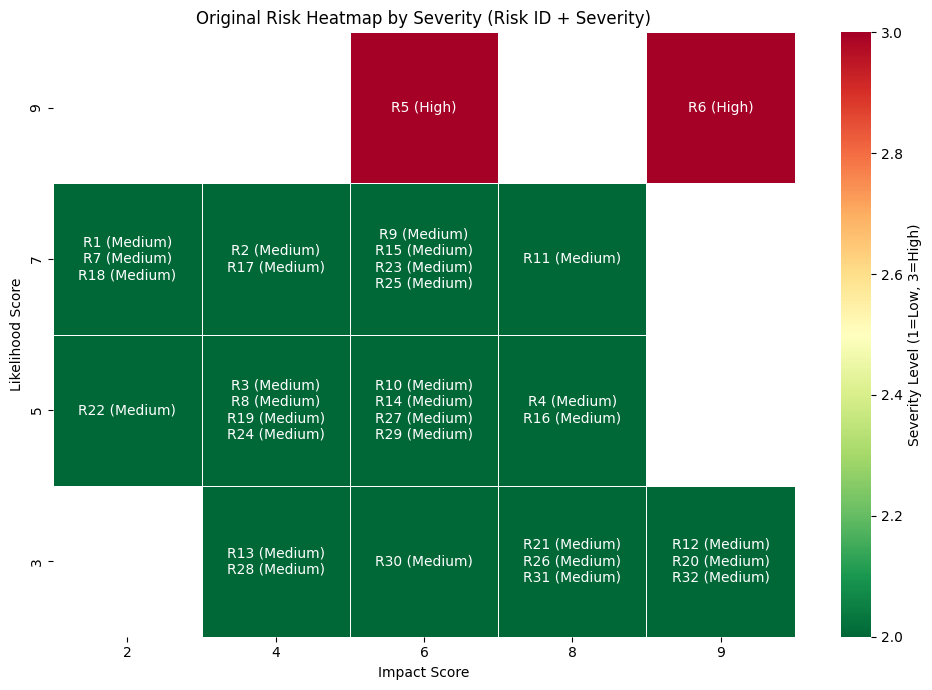

In [37]:
#Create label like "R1 (High)"
df['Label'] = 'R' + df['Risk_ID'].astype(str) + ' (' + df['Severity_Label'] + ')'

#Map severity to numeric scale (for heatmap color)
severity_map = {'Low': 1, 'Medium': 2, 'High': 3}
df['Severity_Num'] = df['Severity_Label'].map(severity_map)

#Create annotation matrix (Risk_ID + Severity_Label)
label_matrix = df.pivot_table(
    index='Likelihood_Score',
    columns='Impact_Score',
    values='Label',
    aggfunc=lambda x: '\n'.join(x)
).fillna('')

#Severity color matrix
pivot_severity = df.pivot_table(
    index='Likelihood_Score',
    columns='Impact_Score',
    values='Severity_Num',
    aggfunc='max'
).sort_index(ascending=False)

#Sort the annotation matrix to match
label_matrix = label_matrix.reindex(index=sorted(label_matrix.index, reverse=True),
                                    columns=sorted(label_matrix.columns))

#Plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(pivot_severity, annot=label_matrix, fmt='', cmap='RdYlGn_r',
            linewidths=0.5, cbar_kws={'label': 'Severity Level (1=Low, 3=High)'})
plt.title("Original Risk Heatmap by Severity (Risk ID + Severity)")
plt.xlabel("Impact Score")
plt.ylabel("Likelihood Score")
plt.tight_layout()
plt.show()


All risks except for R5 and R6 are classified as Medium, highlighting a concentration of moderately probable and impactful risks across 7-Eleven’s retail and infrastructure domains.R5 (High) and R6 (High) fall into the (Likelihood=9, Impact ≥ 5) zone, meeting the threshold for high severity.
These likely represent critical systemic risks (e.g., high-cost disruptions or legal exposures)

We generated 200 synthetic risk records by covering all valid Likelihood–Impact score combinations used at 7-Eleven, then classified each using the same severity rules to balance and enrich the training dataset.

In [24]:
#Define allowed scores
likelihood_values = [1, 3, 5, 7, 9]
impact_values = [1, 2, 4, 6, 8, 9]

#Generate base pairs (30 combinations)
base_pairs = [(l, i) for l in likelihood_values for i in impact_values]

#Repeat each pair 6 times → 180 rows
synthetic_rows = []
for _ in range(6):
    for l, i in base_pairs:
        synthetic_rows.append({
            'Risk_Description': f'Synthetic risk for Likelihood={l}, Impact={i}',
            'Likelihood_Score': l,
            'Impact_Score': i
        })

#Add 20 more random rows to make total 200
np.random.seed(42)
extra_indices = np.random.choice(len(base_pairs), 20)
for idx in extra_indices:
    l, i = base_pairs[idx]
    synthetic_rows.append({
        'Risk_Description': f'Synthetic extra risk for Likelihood={l}, Impact={i}',
        'Likelihood_Score': l,
        'Impact_Score': i
    })

#Convert to DataFrame
synthetic_df = pd.DataFrame(synthetic_rows)

#Apply severity classification
synthetic_df['Severity_Label'] = synthetic_df.apply(classify_severity, axis=1)


We assigned unique Risk_IDs to the synthetic records and merged them with the original 7-Eleven dataset to form a balanced, unified risk dataset ready for training.



In [25]:
#Find the last Risk_ID in your original data
max_id = df['Risk_ID'].max()

#Assign new Risk_IDs to synthetic rows
synthetic_df['Risk_ID'] = range(max_id + 1, max_id + 1 + len(synthetic_df))

#Reorder columns to match original
synthetic_df = synthetic_df[['Risk_ID', 'Risk_Description', 'Likelihood_Score', 'Impact_Score', 'Severity_Label']]

#Combine datasets
combined_df = pd.concat([df, synthetic_df], ignore_index=True)

#Check result
print("Total rows after combining:", combined_df.shape[0])
print("Class distribution:")
print(combined_df['Severity_Label'].value_counts())


Total rows after combining: 232
Class distribution:
Severity_Label
Medium    182
Low        28
High       22
Name: count, dtype: int64


We trained a Random Forest model using 5-fold cross-validation to predict risk severity from Likelihood and Impact scores, and evaluated its performance using accuracy, classification metrics, and a confusion matrix

In [39]:
#Define features (X) and target (y)
X = combined_df[['Likelihood_Score', 'Impact_Score']]
y = combined_df['Severity_Label']

#Initialize the model
model = RandomForestClassifier(n_estimators=100, random_state=42)

#Evaluate with 5-fold cross-validation
scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print(f"✅ Mean Accuracy (5-fold CV): {scores.mean():.2f}")
print("Fold-wise Accuracy:", scores)

#Get predicted labels for evaluation
y_pred = cross_val_predict(model, X, y, cv=5)

#Classification report
print("\n📊 Classification Report:")
print(classification_report(y, y_pred))

#Confusion matrix
print("📉 Confusion Matrix:")
print(confusion_matrix(y, y_pred, labels=['Low', 'Medium', 'High']))


✅ Mean Accuracy (5-fold CV): 1.00
Fold-wise Accuracy: [1. 1. 1. 1. 1.]

📊 Classification Report:
              precision    recall  f1-score   support

        High       1.00      1.00      1.00        22
         Low       1.00      1.00      1.00        28
      Medium       1.00      1.00      1.00       182

    accuracy                           1.00       232
   macro avg       1.00      1.00      1.00       232
weighted avg       1.00      1.00      1.00       232

📉 Confusion Matrix:
[[ 28   0   0]
 [  0 182   0]
 [  0   0  22]]


**Interpretation**

The Random Forest classifier achieved perfect performance with:

100% accuracy across all 5 cross-validation folds

Precision, Recall, and F1-score of 1.00 for all three classes (Low, Medium, High)

Confusion matrix confirming zero misclassifications

The model has perfectly learned the severity classification rule based on Likelihood_Score and Impact_Score, which is expected because the labels are generated from a deterministic rule and the training data now covers all valid risk scenarios.

Class balance achieved through synthetic data generation contributed to equal performance across all classes, including previously underrepresented ones like Low and High.



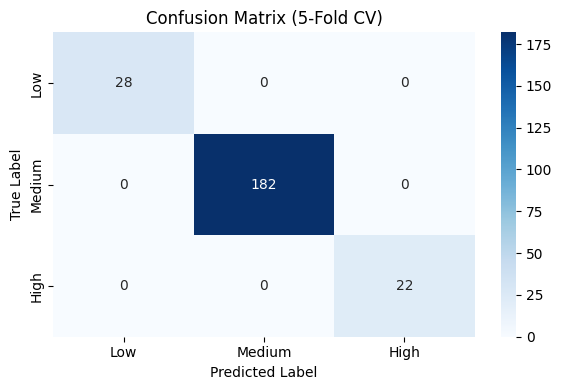

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

#Compute confusion matrix again (if not already done)
labels = ['Low', 'Medium', 'High']
cm = confusion_matrix(y, y_pred, labels=labels)

#Plot the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix (5-Fold CV)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


We trained the model on the full dataset and plotted feature importances to understand whether Likelihood or Impact scores had a stronger influence on predicting risk severity.

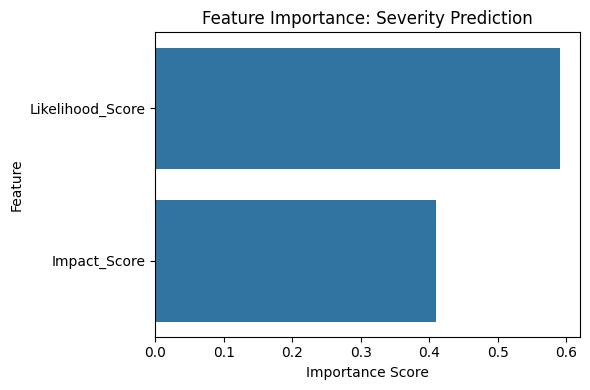

In [41]:
#Fit the model on the full dataset (required to get feature importance)
model.fit(X, y)

#Get feature importances
importances = model.feature_importances_
features = X.columns

#Plot the importance
plt.figure(figsize=(6, 4))
sns.barplot(x=importances, y=features)
plt.title("Feature Importance: Severity Prediction")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


Both Likelihood Score and Impact Score are critical inputs

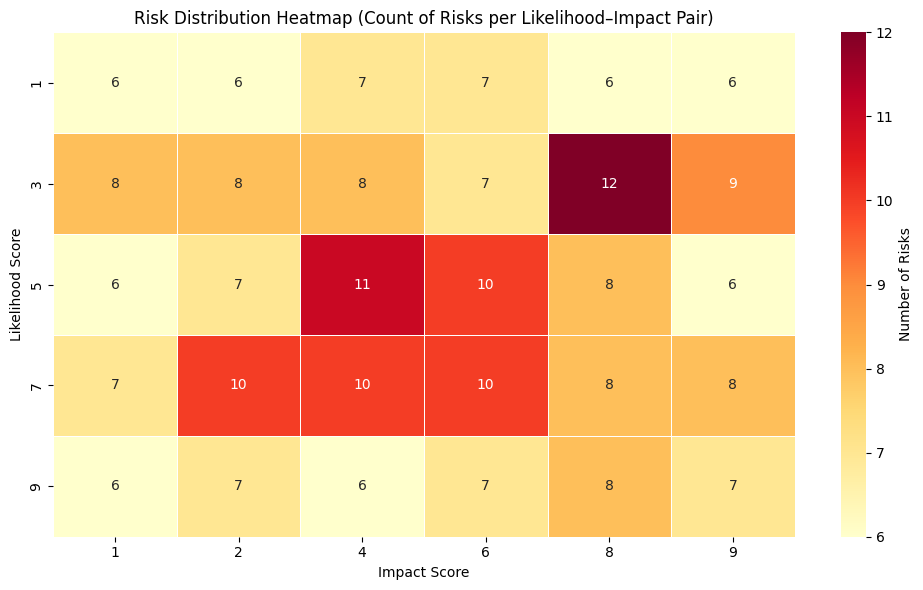

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a pivot table counting number of risks per (Likelihood, Impact) cell
heatmap_data = combined_df.groupby(['Likelihood_Score', 'Impact_Score']).size().unstack(fill_value=0)

# Plot the count heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlOrRd', linewidths=0.5,
            cbar_kws={'label': 'Number of Risks'})
plt.title("Risk Distribution Heatmap (Count of Risks per Likelihood–Impact Pair)")
plt.xlabel("Impact Score")
plt.ylabel("Likelihood Score")
plt.tight_layout()
plt.show()
